# Imports

In [1]:
import os
import random
from types import SimpleNamespace

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Step 1: Prepare and Explore Data

In [2]:
root_dir = "../data/lions_cheetahs_images/"  # Insert your data here
sub_folders = ["Cheetahs", "Lions"]  # Insert your classes here
labels = [0, 1]

In [3]:
data = []

for s, l in zip(sub_folders, labels):
    for r, d, f in os.walk(root_dir + s):
        for file in f:
            if ".jpg" in file:
                data.append((os.path.join(s, file), l))

In [4]:
df = pd.DataFrame(data, columns=["file_name", "label"])

In [5]:
df

,file_name,label
0,Cheetahs\00bb45a8568a3474.jpg,0
1,Cheetahs\00d9eb862ba3dfc6.jpg,0
2,Cheetahs\012f5ecbf49e1da0.jpg,0
3,Cheetahs\01750ba1a197e3ad.jpg,0
4,Cheetahs\029b39c0b65ebeb3.jpg,0
...,...,...
137,Lions\e8c4adb3a073997c.jpg,1
138,Lions\eab5a653e7bc2c95.jpg,1
139,Lions\eb226814a3585764.jpg,1
140,Lions\eb551b1c169fe188.jpg,1


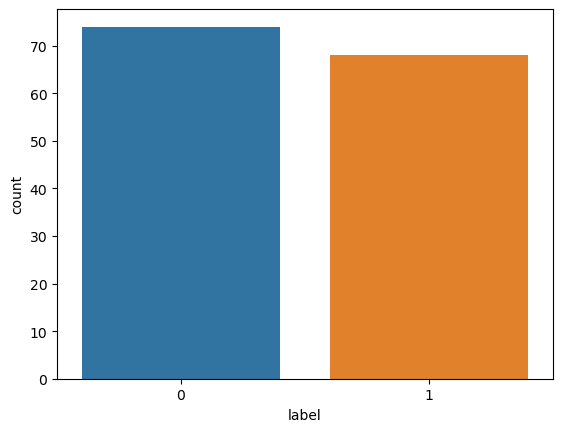

In [6]:
sns.countplot(data=df, x="label");

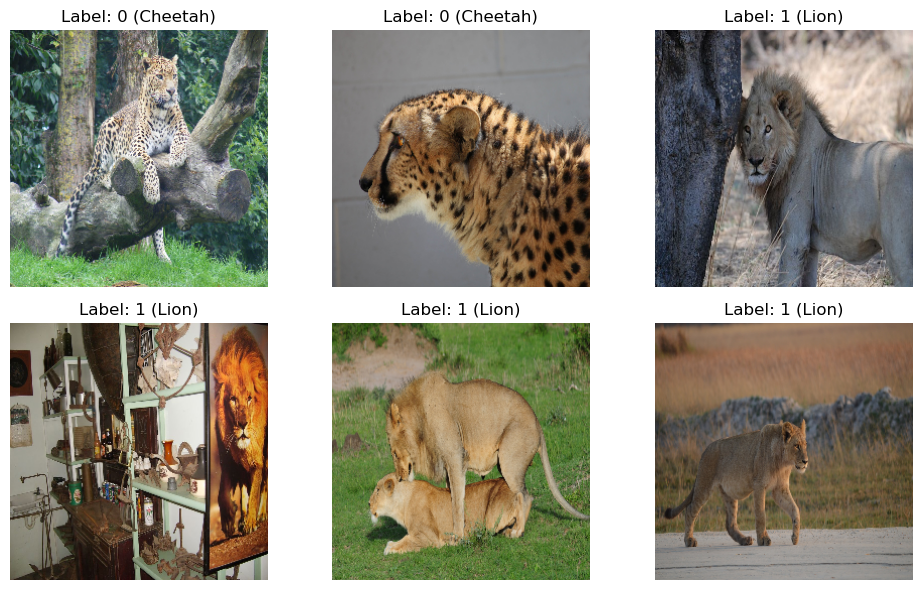

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

idx = 72
for i in range(2):
    for j in range(3):
        label = df.label[idx]
        file_path = os.path.join(root_dir, df.file_name[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image
        image = cv2.resize(image, (256, 256))

        ax[i, j].imshow(image)
        ax[i, j].set_title(f"Label: {label} ({'Lion' if label == 1 else 'Cheetah'})")
        ax[i, j].axis("off")
        idx = idx + 1

plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Step 2: Build a Baseline

Next, we will build a baseline. A baseline consists of three key components:

- A data pipeline for loading images
- A model with loss function and optimizer
- A training pipeline, including a cross-validation strategy

Because training a Deep Learning model includes a lot of experimentation, we want to be able to switch out specific parts of the code quickly. Thus, we will try to make the following code as modular as possible and work with a configuration for tuning:

In [9]:
cfg = SimpleNamespace(**{})

In [10]:
cfg

namespace()

We will add the configurable parameters as we go along.

### Build a data pipeline for loading images

Below you can find a template to customize the `Dataset` class.

In [11]:
class CustomDataset(Dataset):
    def __init__(self, df):
        # Initialize anything you need later here ...
        self.df = df
        self.X = ...
        self.y = ...
        # ...

    # Get the number of rows in the dataset
    def __len__(self):
        return len(self.df)

    # Get a sample of the dataset
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

When loading your dataset, you can also perform any required preprocessing, such as transforms or image standardization. This happens in `__getitem__()`.

In this example, we first load the image from the root directory (`cfg.root_dir`) with OpenCV and convert it to the RGB color space. Then we will apply basic transforms: Resize the image (`cfg.image_size`) and convert the image from a NumPy array to a tensor. Finally, we will normalize the values of the image to be in the [0, 1] range by dividing the values by 255.

In [12]:
cfg.root_dir = root_dir  # Insert your data here
cfg.image_size = 256

In [13]:
cfg

namespace(root_dir='../data/lions_cheetahs_images/', image_size=256)

In [14]:
class CustomDataset(Dataset):
    def __init__(self, cfg, df, transform=None, mode="val"):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df["file_name"].values
        self.labels = df["label"].values

        if transform:
            self.transform = transform
        else:
            self.transform = A.Compose(
                [
                    A.Resize(cfg.image_size, cfg.image_size),
                    ToTensorV2(),
                ]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = os.path.join(self.root_dir, self.file_names[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentations
        augmented = self.transform(
            image=image
        )  # transform will return a dictionary with a single key image.
        image = augmented["image"]  # Value at that key will contain an augmented image.

        # Normalize because ToTensorV2() doesn't normalize the image
        image = image / 255

        return image, label

Next, we need a `Dataloader` to feed the samples of the `Dataset` to the neural network in batches because we (probably) don’t have enough RAM to feed all the images to the model at once.

You need to provide the `Dataloader` the instance of the `Dataset` you want to navigate, the size of the batches (`cfg.batch_size`), and the information on whether to shuffle the data.

In [15]:
cfg.batch_size = 32

In [16]:
cfg

namespace(root_dir='../data/lions_cheetahs_images/',
          image_size=256,
          batch_size=32)

In [17]:
example_dataset = CustomDataset(cfg, df)

In [18]:
example_dataloader = DataLoader(
    example_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=0,
)

The batch size should be fixed throughout the training and not be tuned [[2]](https://www.youtube.com/watch?v=_mzrfMA8Qx4). Because the training speed is related to the batch size, we want to use the biggest batch size possible. Start with a batch size of 32 and then increase it in powers of two (64, 128, etc.) until you get a memory error, and then use the last batch size.

When you iterate over the `Dataloader`, it will give you batches of samples from the customized `Dataset`. Let’s retrieve the first batch for a sanity check:

In [19]:
for image_batch, label_batch in example_dataloader:
    print(image_batch.shape)
    print(label_batch.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


The `Dataloader` returns the image batch and a label batch. The `image_batch` is a tensor of the shape `(32, 3, 256, 256)`. This is a batch of 32 (`batch_size`) images with the shape `(3, 256, 256)` (`color_channels`, `image_height`, `image_width`). The `label_batch` is a tensor of the shape (`32`). These are the corresponding labels to the 32 images.

In [20]:
train_df.shape

(127, 2)

In [21]:
y = train_df.label

train_df, valid_df, y_train, y_test = train_test_split(
    train_df, y, test_size=0.2, random_state=42
)

<img src="images/data_split.png" style="width:700px;height:100px;background-color:white">

In [22]:
train_dataset = CustomDataset(cfg, train_df)
valid_dataset = CustomDataset(cfg, valid_df)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=False)

### Prepare the model

**Fantastic backbones and where to find them** — Now, which of these pre-trained models should you choose, and where do you get these from?

In this tutorial, we will use `timm` — a Deep Learning library containing a collection of state-of-the-art computer vision models created by Ross Wightman — to get pre-trained models. (You can use `torchvision.models` for pre-trained models, but I personally find it easier to switch out backbones during experimentation with `timm`.)

In [23]:
cfg.n_classes = 2
cfg.backbone = "resnet18"

In [24]:
cfg

namespace(root_dir='../data/lions_cheetahs_images/',
          image_size=256,
          batch_size=32,
          n_classes=2,
          backbone='resnet18')

In [25]:
model = timm.create_model(cfg.backbone, pretrained=True, num_classes=cfg.n_classes)

There are many different models in the ResNet family, such as ResNet18, ResNet34, etc., where the number stands for how many layers the network has. As a (very rough) rule of thumb: The higher the number of layers, the better the performance. You can print `timm.list_models('*resnet*')` to see what other models are available.

`num_classes = cfg.n_classes` — Because the model was pre-trained on ImageNet, you will get a classifier with the 1000 classes that are in ImageNet. Thus, you need to remove the ImageNet classifier and define how many classes you have in your problem. If you set `num_classes = 0`, you will get the model without a classifier.

To check output size, you can pass in a sample batch `X` with 3 channels of random values in the image size.

In [26]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)

In [27]:
X.shape

torch.Size([32, 3, 256, 256])

In [28]:
y = model(X)

In [29]:
y.shape

torch.Size([32, 2])

It outputs `torch.Size([cfg.batch_size, cfg.n_classes])`

### Prepare loss function and optimizer

Next, to train a model, there are two key ingredients:

- a loss function (criterion),
- an optimization algorithm (optimizer), and
- optionally a learning rate scheduler.

**Loss function** — Common loss functions are the following:

- **Binary cross-entropy (BCE) loss** for binary classification.
- **Categorical cross-entropy loss** for multi-class classification.
- **Mean squared loss** for regression.

Although we have a binary classification problem, you can also use categorical cross-entropy loss. If you like, you can switch out the loss function with BCE.

In [30]:
criterion = nn.CrossEntropyLoss()

**Optimizer** — The optimization algorithm minimizes the loss function (in our case, the cross-entropy loss). There are many different optimizers available. Let’s use a popular one: `Adam`.

In [31]:
cfg.learning_rate = 1e-4

In [32]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg.learning_rate,
    weight_decay=0,
)

**Learning rate scheduler** — A learning rate scheduler adapts the value of the learning rate during the training process. Although you don’t have to use a learning rate scheduler, using one can help the algorithm converge faster. This is because if the learning rate stays constant, it can prevent you from finding the optimum if it is too large, and it can take too long to converge if it is too small.

There are many different learning rate schedulers available, but Kaggle Grandmasters recommend using **cosine decay as a learning rate scheduler for fine-tuning** [[2]](https://www.youtube.com/watch?v=_mzrfMA8Qx4).

In [33]:
cfg.lr_min = 1e-5
cfg.epochs = 5

In [34]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
    eta_min=cfg.lr_min,
)

`T_max` defines the half period and should be equal to the maximum number of iterations

(`np.ceil(len(train_dataloader.dataset) /cfg.batch_size)*cfg.epochs`).

The resulting learning rates will look as follows over the course of a training run:

<img src="images/learning_rate.png" style="width:700px;height:250px;background-color:white">

**Metric** — While we’re at it, let’s also define a metric to evaluate the model’s overall performance. Again, there are many different metrics. For this example, we will use accuracy as the metric:

In [35]:
def calculate_metric(y, y_pred):
    metric = accuracy_score(y, y_pred)
    return metric

Don’t confuse the metric with the loss function. The loss function is used to optimize the learning function during training, while the metric measures the model’s performance after the training.

### Setup a training pipeline

A model is typically trained in iterations. One iteration is called an epoch. Training from scratch usually requires many epochs, while fine-tuning requires only a few (roughly 5 to 10) epochs.

In each epoch, the model is trained on the full training data and then validated on the full validation data. We will now define two functions: One function to train (`train_an_epoch()`) and one function to validate the model on an epoch (`validate_an_epoch()`).

In [36]:
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
cfg

namespace(root_dir='../data/lions_cheetahs_images/',
          image_size=256,
          batch_size=32,
          n_classes=2,
          backbone='resnet18',
          learning_rate=0.0001,
          lr_min=1e-05,
          epochs=5,
          device=device(type='cpu'))

In [38]:
def train_one_epoch(dataloader, model, optimizer, scheduler, cfg):
    # Training mode
    model.train()

    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            y = y.detach().cpu().numpy().tolist()
            y_pred = y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)

    return metric, loss

Let’s go through it step-by-step:

1. Set the model to the training mode. The model can also be in evaluation mode. This mode affects the behavior of the layers `Dropout` and `BatchNorm` in a model.
2. Iterate over the training data in small batches. The samples and labels need to be moved to GPU if you use one for faster training (`cfg.device`).
3. Clear the last error gradient of the optimizer.
4. Do a forward pass of the input through the model.
5. Calculate the loss for the model output.
6. Backpropagate the error through the model.
7. Update the model to reduce the loss.
8. Step the learning rate scheduler.
9. Calculate the loss and metric for statistics. Because the predictions will be Tensors on the GPU, just like the inputs, we need to detach the Tensor from the automatic differentiation graph and call the NumPy function to convert them to NumPy arrays

In [39]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()

    final_y = []
    final_y_pred = []
    final_loss = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)

            # Forward: Calculate loss
            loss = criterion(y_pred, y)

            # Covert y and y_pred to lists
            y = y.detach().cpu().numpy().tolist()
            y_pred = y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)

    return metric, loss

Let’s go through it step-by-step:

1. Set the model to the evaluation mode.
2. Iterate over the validation data in small batches. The samples and labels need to be moved to GPU if you use one for faster training.
3. Do a forward pass of the input through the model.
4. Calculate the loss and metric for statistics.

### Cross-validation strategy

Now, we are not yet done with the training pipeline. Earlier, we divided the training data into training and validation data. But partitioning the available data into two fixed sets limits the number of training samples.

Instead, we will use a cross-validation strategy by splitting the training data into k folds. The model is then trained in k separate iterations, in which the model is trained on k-1 folds and validated on one fold for each iteration while the folds switch at every iteration as shown below:

<img src="images/cv.png" style="width:700px;height:300px;background-color:white">

In this example, we are using `StratifiedKFold` to create the splits. You could use `KFold` instead but `StratifiedKFold` has the advantage that it preserves the class distribution.

In [40]:
cfg.n_folds = 5

In [41]:
cfg

namespace(root_dir='../data/lions_cheetahs_images/',
          image_size=256,
          batch_size=32,
          n_classes=2,
          backbone='resnet18',
          learning_rate=0.0001,
          lr_min=1e-05,
          epochs=5,
          device=device(type='cpu'),
          n_folds=5)

In [42]:
# Create a new column for cross-validation folds
df["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=cfg.n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X=df, y=df.label)):
    df.loc[val_, "kfold"] = fold

In [43]:
df

,file_name,label,kfold
0,Cheetahs\00bb45a8568a3474.jpg,0,0
1,Cheetahs\00d9eb862ba3dfc6.jpg,0,0
2,Cheetahs\012f5ecbf49e1da0.jpg,0,0
3,Cheetahs\01750ba1a197e3ad.jpg,0,0
4,Cheetahs\029b39c0b65ebeb3.jpg,0,0
...,...,...,...
137,Lions\e8c4adb3a073997c.jpg,1,4
138,Lions\eab5a653e7bc2c95.jpg,1,4
139,Lions\eb226814a3585764.jpg,1,4
140,Lions\eb551b1c169fe188.jpg,1,4


In [44]:
# The following code puts the data with kfold=4 into valid_df
# and the rest into train_df (comment by me)
# Later on, I understands why the following codes are used

for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

In [45]:
train_df.shape

(114, 3)

In [46]:
valid_df.shape

(28, 3)

In [47]:
train_df["kfold"].unique()

array([0, 1, 2, 3], dtype=int64)

In [48]:
valid_df["kfold"].unique()

array([4], dtype=int64)

In [49]:
train_df["label"].value_counts()

0    60
1    54
Name: label, dtype: int64

In [50]:
valid_df["label"].value_counts()

0    14
1    14
Name: label, dtype: int64

### Adding data augmentation

We can use some prepared data augmentations from the `albumentations` package, such as:

- Rotating images (`A.Rotate()`)
- Horizontal flipping (`A.HorizontalFlip()`)
- Cutout [4] (`A.CoarseDropout()`)

Earlier, we defined a basic transform to resize and convert the image to a tensor. We will continue to use it for the validation and testing datasets because they don’t need any augmentations. For the training dataset, we create a new transform `transform_soft`, which has the three above augmentations in addition to the resizing and conversion to tensor.

In [51]:
transform_soft = A.Compose(
    [
        A.Resize(cfg.image_size, cfg.image_size),
        A.Rotate(p=0.6, limit=[-45, 45]),
        A.HorizontalFlip(p=0.6),
        A.CoarseDropout(max_holes=1, max_height=64, max_width=64, p=0.3),
        ToTensorV2(),
    ]
)

You can control the percentage of images the augmentations are applied to with the parameter `p`.

### Putting it all together

Before we touch anything, let’s set ourselves up for success and fix the random seeds to ensure reproducible results.

In [52]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

Next, we will write a `fit()` function that fits the model for all epochs. The function iterates over the number of epochs, while the training and validation functions contain inner loops that iterate over the batches in the training and validation datasets, as discussed in the section about the training pipeline.

In [53]:
cfg.seed = 42

In [54]:
def fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")

        set_seed(cfg.seed + epoch)

        acc, loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg)

        print(f"Loss: {loss:.4f} Acc: {acc:.4f}")
        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)

            print(f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

For visualization purposes, we will also create plots of the loss and accuracy on the training and validation sets:

In [55]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(range(len(loss)), loss, color="darkgrey", label="train")
    ax[0].plot(range(len(val_loss)), val_loss, color="cornflowerblue", label="valid")
    ax[0].set_title("Loss")

    ax[1].plot(range(len(acc)), acc, color="darkgrey", label="train")
    ax[1].plot(range(len(val_acc)), val_acc, color="cornflowerblue", label="valid")
    ax[1].set_title("Metric (Accuracy)")

    for i in range(2):
        ax[i].set_xlabel("Epochs")
        ax[i].legend(loc="upper right")
    plt.show()

When we combine everything, it will look as follows:

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.23s/it]


Loss: 0.5639 Acc: 0.6460


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Val Loss: 0.3264 Val Acc: 0.8621
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.38s/it]


Loss: 0.1509 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Val Loss: 0.3128 Val Acc: 0.8276
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.65s/it]


Loss: 0.0788 Acc: 0.9823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Val Loss: 0.2787 Val Acc: 0.8621
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.59s/it]


Loss: 0.0728 Acc: 0.9646


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Val Loss: 0.2049 Val Acc: 0.9310
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.63s/it]


Loss: 0.0353 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Val Loss: 0.1699 Val Acc: 0.9310


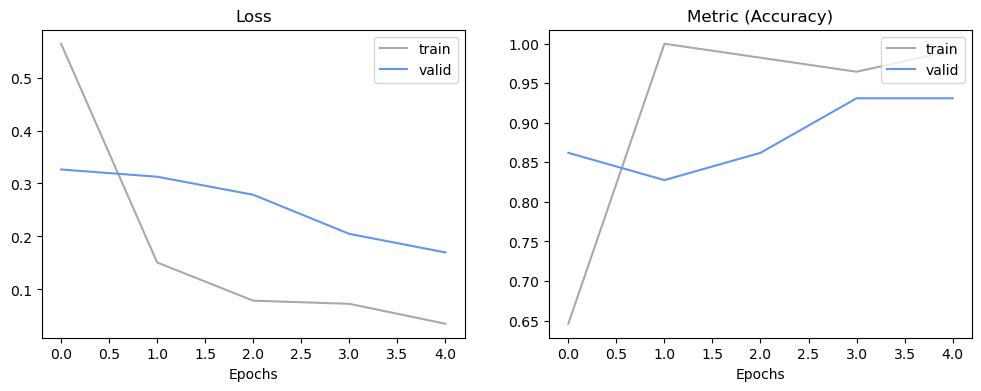

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.61s/it]


Loss: 0.0798 Acc: 0.9646


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Val Loss: 0.0190 Val Acc: 1.0000
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.61s/it]


Loss: 0.0533 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Val Loss: 0.0161 Val Acc: 1.0000
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.44s/it]


Loss: 0.0550 Acc: 0.9823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Val Loss: 0.0141 Val Acc: 1.0000
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.47s/it]


Loss: 0.0539 Acc: 0.9823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Val Loss: 0.0126 Val Acc: 1.0000
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.61s/it]


Loss: 0.0546 Acc: 0.9823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Val Loss: 0.0125 Val Acc: 1.0000


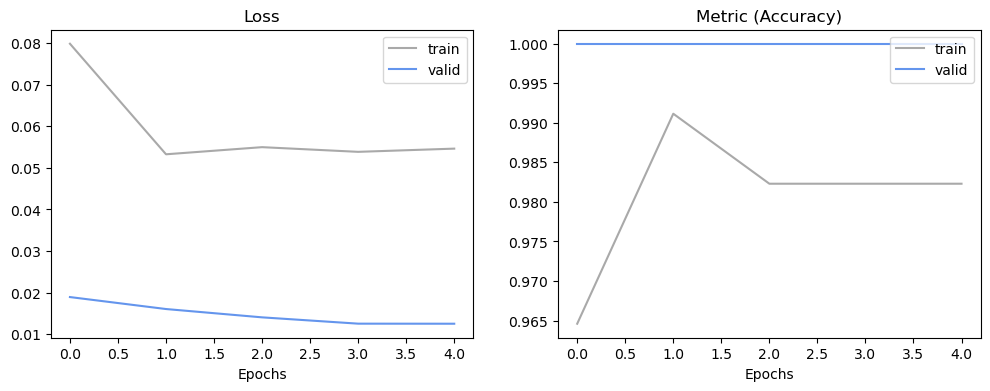

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]


Loss: 0.0509 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Val Loss: 0.0125 Val Acc: 1.0000
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.48s/it]


Loss: 0.0378 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Val Loss: 0.0116 Val Acc: 1.0000
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.66s/it]


Loss: 0.0330 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Val Loss: 0.0108 Val Acc: 1.0000
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.79s/it]


Loss: 0.0498 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Val Loss: 0.0105 Val Acc: 1.0000
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.54s/it]


Loss: 0.0371 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Val Loss: 0.0097 Val Acc: 1.0000


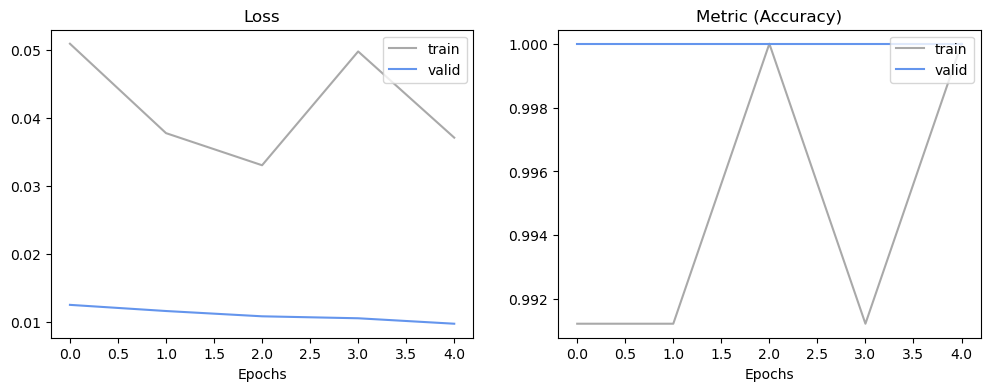

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.37s/it]


Loss: 0.0333 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Val Loss: 0.0123 Val Acc: 1.0000
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.37s/it]


Loss: 0.0206 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Val Loss: 0.0122 Val Acc: 1.0000
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.39s/it]


Loss: 0.0267 Acc: 0.9912


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Val Loss: 0.0124 Val Acc: 1.0000
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.39s/it]


Loss: 0.0263 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Val Loss: 0.0121 Val Acc: 1.0000
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.49s/it]


Loss: 0.0258 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Val Loss: 0.0119 Val Acc: 1.0000


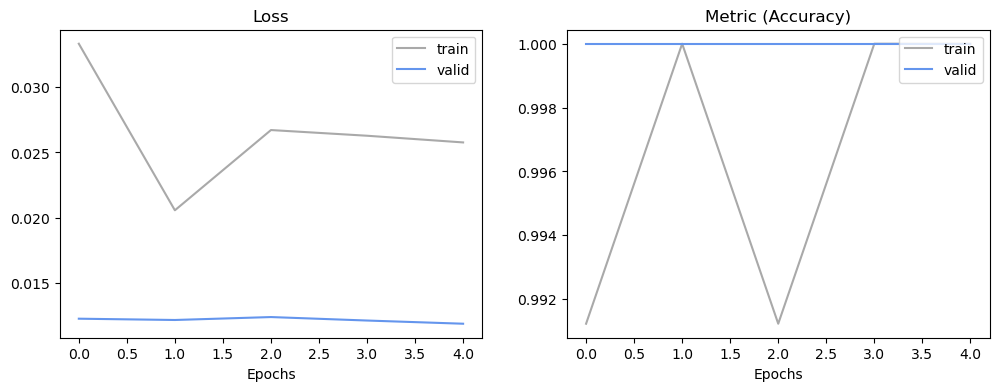

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.98s/it]


Loss: 0.0195 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Val Loss: 0.0088 Val Acc: 1.0000
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.95s/it]


Loss: 0.0225 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Val Loss: 0.0083 Val Acc: 1.0000
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.76s/it]


Loss: 0.0145 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Val Loss: 0.0084 Val Acc: 1.0000
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.91s/it]


Loss: 0.0179 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Val Loss: 0.0084 Val Acc: 1.0000
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.60s/it]


Loss: 0.0280 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Val Loss: 0.0078 Val Acc: 1.0000


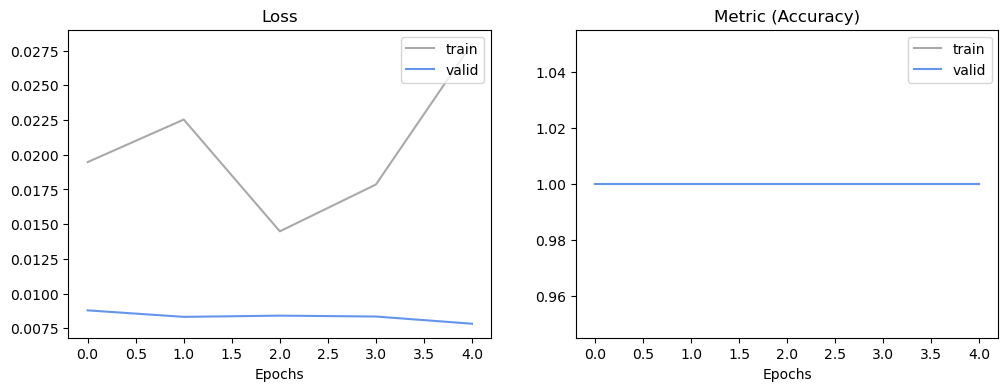

In [56]:
model = timm.create_model(cfg.backbone, pretrained=True, num_classes=cfg.n_classes)

model = model.to(cfg.device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg.learning_rate,
    weight_decay=0,
)

for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = CustomDataset(cfg, train_df, transform=transform_soft)
    valid_dataset = CustomDataset(cfg, valid_df)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=0,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=0,
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
        eta_min=cfg.lr_min,
    )

    acc, loss, val_acc, val_loss, model = fit(
        model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader
    )

    visualize_history(acc, loss, val_acc, val_loss)

# Step 3: Run Experiments

### Setup experiment tracking

If you are an absolute beginner, I recommend starting simple and tracking your experiments manually in a spreadsheet at first. Open an empty spreadsheet and create columns for all inputs, such as:

- backbone,
- learning rate,
- epochs,
- augmentations, and
- image size
and outputs, such as loss and metrics for training and validation, you want to track.

### Experimentation and hyperparameter tuning

Now that you have an experiment tracking system let’s run some experiments. You can start by tweaking the following hyperparameters:

- Number of training steps: range of 2 to 10
- Learning rate: range of 0.0001 to 0.001
- Image size: range of 128 to 1028
- Backbone: Try different backbones. First, try deeper models from the ResNet family (print `timm.list_models('*resnet*')` to see what other models are available), then try a different backbone family like `timm.list_models('*densenet*')` or `timm.list_models('*efficientnet*')`

# Step 4: Make Predictions (Inference)

In [57]:
test_dataset = CustomDataset(cfg, test_df)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0,
)

dataloader = test_dataloader

# Validation mode
model.eval()

final_y = []
final_y_pred = []

# Iterate over data
for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    X = batch[0].to(cfg.device)
    y = batch[1].to(cfg.device)

    with torch.no_grad():
        # Forward: Get model outputs
        y_pred = model(X)

        # Covert y and y_pred to lists
        y = y.detach().cpu().numpy().tolist()
        y_pred = y_pred.detach().cpu().numpy().tolist()

        # Extend original list
        final_y.extend(y)
        final_y_pred.extend(y_pred)

# Calculate statistics
final_y_pred_argmax = np.argmax(final_y_pred, axis=1)
metric = calculate_metric(final_y, final_y_pred_argmax)

test_df["prediction"] = final_y_pred_argmax

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


In [58]:
test_df

,file_name,label,prediction
131,Lions\c583b0a77ebc4249.jpg,1,1
19,Cheetahs\113fbf2203ccef57.jpg,0,0
81,Lions\055dbbcca8626dbb.jpg,1,1
96,Lions\2240d64fa24a7c97.jpg,1,1
56,Cheetahs\8b48ed579956d124.jpg,0,0
12,Cheetahs\09017fd0f60f309a.jpg,0,0
98,Lions\26d8d961177e64e3.jpg,1,1
65,Cheetahs\c65aae5dd1d75984.jpg,0,0
66,Cheetahs\c8f2e212394ed401.jpg,0,0
18,Cheetahs\11377ee99115ffff.jpg,0,0


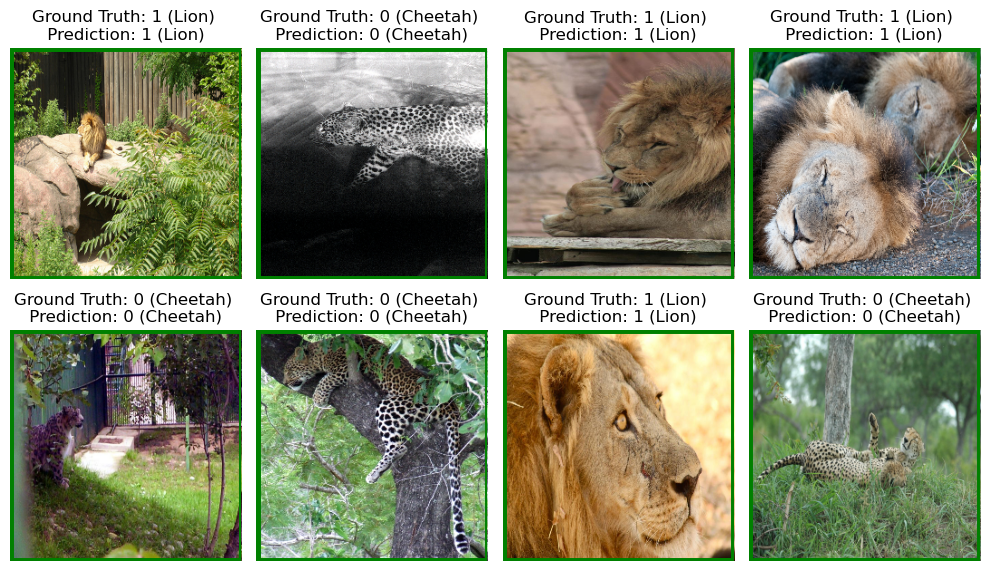

In [59]:
from matplotlib.patches import Rectangle

for idx, batch in enumerate(test_dataloader):
    fig, ax = plt.subplots(2, 4, figsize=(10, 6))

    idx = 0
    for i in range(2):
        for j in range(4):
            label = batch[1][idx]
            image = batch[0][idx]
            pred = final_y_pred_argmax[idx]

            # Reshape image
            image = image.permute(1, 2, 0)

            ax[i, j].imshow(image)
            ax[i, j].set_title(
                f"Ground Truth: {label} ({'Lion' if label == 1 else 'Cheetah'}) \n Prediction: {pred} ({'Lion' if pred == 1 else 'Cheetah'}) "
            )
            ax[i, j].axis("off")
            idx = idx + 1

            color = "green" if label == pred else "red"
            ax[i, j].add_patch(
                Rectangle(
                    (0, 0),
                    cfg.image_size,
                    cfg.image_size,
                    alpha=1,
                    edgecolor=color,
                    linewidth=5,
                    fill=None,
                )
            )
    plt.tight_layout()
    plt.show();